# Trends: Test and Outputs

In [1]:
# Import packages
from matplotlib import pyplot as plt
from importlib import reload
import seaborn as sns
import pandas as pd
import numpy as np
import datetime
import random
import scipy
import math

# Import model classes
from substation import Substation
from PV import PV

## Model Settings

In [ ]:
resload_dict = {'HouseNew': 10,
                'HouseOld' : 10, 
                'HouseDH': 0, 
                'ApartmentNewDH': 0
               }


# Energy Efficiency

In [ ]:
def test_efficiency():
    efficiency_percent = 0.3 # Reduce values with 30%
    num_loads = 20
    station = Substation('Stockholm')
    
    # Add loads to substation
    for load,num in resload_dict.items():
        station.add_residential_load(load,num)
    
    # Reduce data to 1 year (jan-dec)
    station.update_aggregated_col()
    station.filter_whole_years(jan_start = True, num = 1)
    
    # Calculate max and load curve before trend
    max_before = station.dataframe['AggregatedLoad'].max()
    before = station.dataframe['AggregatedLoad'].sort_values(ascending=False).tolist()
    
    # Introduce efficiency trend
    station.introduce_efficiency(percent = efficiency_percent, num = num_loads)
    
    # Calculate max and load curve after trend
    station.update_aggregated_col()
    max_after = station.dataframe['AggregatedLoad'].max()
    after = station.dataframe['AggregatedLoad'].sort_values(ascending=False).tolist()
    
    # Plot load duration curves of before and after
    t = np.linspace(0, len(before)+1,len(before))
    plt.plot(t, before, label='Substation without EE') # plotting t, a separately 
    plt.plot(t, after, label='Substation with EE') # plotting t, b separately
    plt.title('Substation Load Duration Curve')
    plt.legend(loc='upper right')
    plt.xlabel('Hours')
    plt.ylabel('Consumption [kWh]')
    plt.show()
    
    # Print
    print('The maximal instant consumption of the substation with {} loads is {} without any energy efficiency and {} with a {}% reduction.'.format(station.ID_count,max_before,max_after, int(efficiency_percent*100)))
    print('Through {}% energy efficency of {} loads, out of {}, the peak consumption is reduced by {}%'.format(int(efficiency_percent*100),num_loads, station.ID_count, round((1-(max_after/max_before))*100,2)))
%matplotlib notebook    
test_efficiency()

# PV

In [ ]:
def test_pv():
    station = Substation('Stockholm')
    
    # Add loads to substation
    for load,num in resload_dict.items():
        station.add_residential_load(load,num)
    
    # Calculate 1 year consumption with and without PV
    station.update_aggregated_col()
    station.filter_whole_years(jan_start = True, num = 1)
    station.add_PV(size = 400)
    before = station.dataframe['AggregatedLoad'].sort_values(ascending=False).tolist()
    station.update_aggregated_col()
    after = station.dataframe['AggregatedLoad'].sort_values(ascending=False).tolist()
    
    # Plot load duration curves of before and after
    t = np.linspace(0, len(before)+1,len(before))
    plt.plot(t, before, label='Substation without PV') # plotting t, a separately 
    plt.plot(t, after, label='Substation with PV') # plotting t, b separately
    plt.title('Substation Load Duration Curve')
    plt.legend(loc='upper right')
    plt.xlabel('Hours')
    plt.ylabel('Consumption [kWh]')
    plt.show()
    
    '''
    station.print_insights(duration_curve = True,
                           month_plot = False, 
                           weekday_plot = False, 
                           hour_plot = False)
    '''
%matplotlib notebook
test_pv()

# Office Load

In [ ]:
def test_office():
    station = Substation('Stockholm')
    
    #add loads
    for load,num in resload_dict.items():
        station.add_residential_load(load,num)
    
    '''station.print_insights(duration_curve = True,
                        month_plot = False, 
                        weekday_plot = False, 
                        hour_plot = False)''' 
    station.filter_whole_years(num = 1, jan_start = True)
    station.calculate_norm()
    before = station.dataframe['AggregatedLoad'].sort_values(ascending=False).tolist()
    
    print('No Office')
    print('Hourly average: ', station.mu)
    print('Hourly max: ', station.dataframe['AggregatedLoad'].max())
    
    print('\n')
    station.add_office()
    print('{} Office'.format(station.office_count))
    '''station.print_insights(duration_curve = True,
                        month_plot = False, 
                        weekday_plot = False, 
                        hour_plot = False)''' 
    station.calculate_norm()
    
    print('Hourly average: ', station.mu)
    print('Hourly max: ', station.dataframe['AggregatedLoad'].max())
    
    after = station.dataframe['AggregatedLoad'].sort_values(ascending=False).tolist()
    office = station.dataframe[station.ID_count].sort_values(ascending=False).tolist()

    
    # Plot load duration curves of before and after
    t = np.linspace(0, len(before)+1,len(before))
    plt.plot(t, before, label='Substation without office') 
    plt.plot(t, after, label='Substation with {} office'.format(station.office_count))
    plt.plot(t, office, label='Only Office')
    plt.title('Substation Load Duration Curve')
    plt.legend(loc='upper right')
    plt.xlabel('Hours')
    plt.ylabel('Consumption [kWh]')
    plt.show()
    
test_office()

In [ ]:
#offices from datasets
from office import Office
office = Office(ID = 1, region='Stockholm', size = 12402, start = '2019-01-01', end = '2020-01-01')
office.dataframe.head()
print(office.kwhref, office.kwhp)
#office.be_random(sigma=0.7)

# Static Flex

<IPython.core.display.Javascript object>


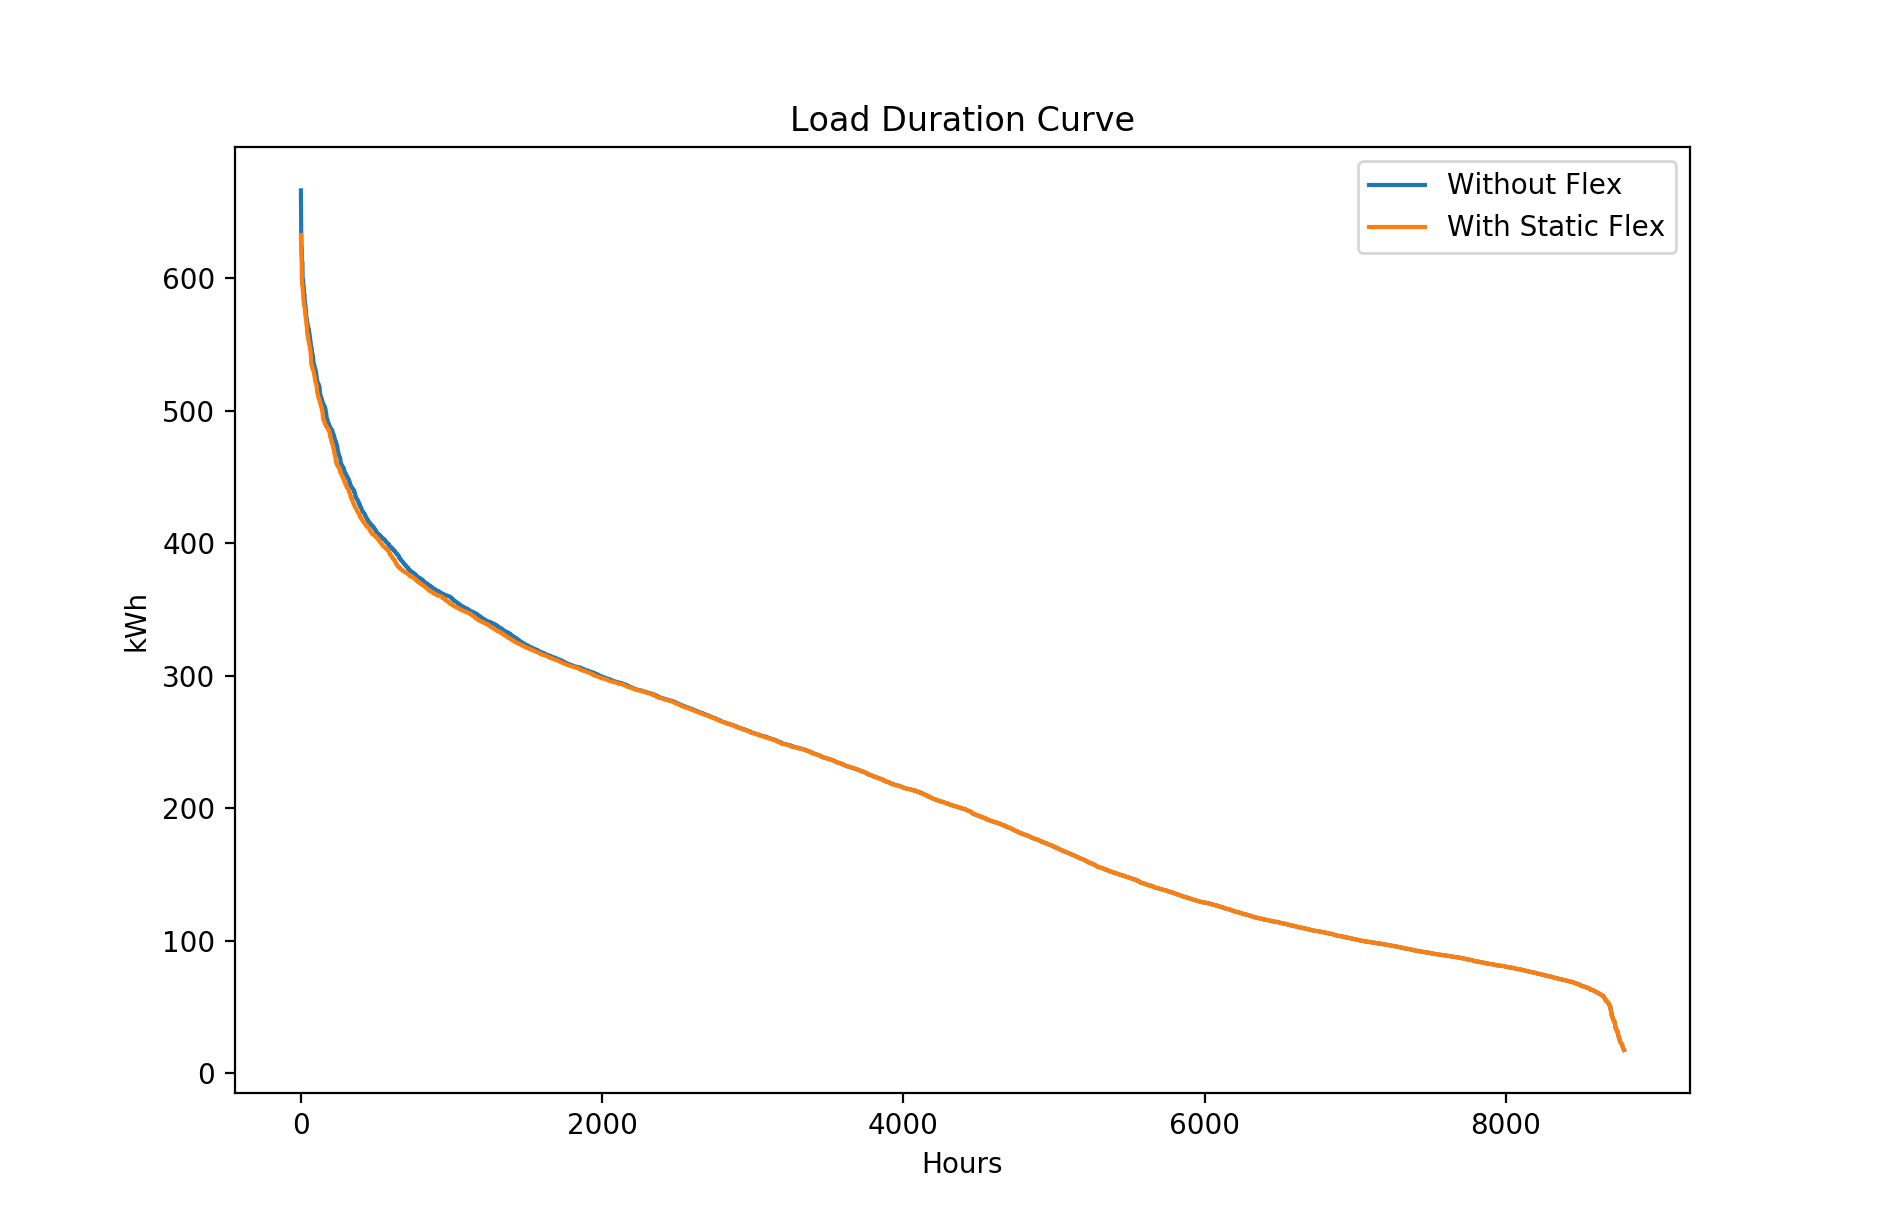

The maximal instant consumption of the substation with 100 loads is 666.2419999999998 without demand side flexibility and 632.489 with 30 flexible loads.
Before flex peak occured at 2016-01-15 18:00:00 and after peak occurs at 2016-01-15 07:00:00.


In [23]:
def test_flex(days = 50, percent_loads = 0.30, reduction = 0.70):
    # create empty station
    station = Substation('Stockholm')
    
    resload_dict = {'HouseNew': 50,
                'HouseOld' : 50, 
                'HouseDH': 0, 
                'ApartmentNewDH': 0
               }
    
    #add loads
    for load,num in resload_dict.items():
        station.add_residential_load(load,num)
    station.filter_whole_years(jan_start = True, num = 1)

    #find instant max 
    station.update_aggregated_col()
    max_consumption = station.dataframe['AggregatedLoad'].max()
    max_time_before = station.find_max()
    
    
    #infer flexible loads
    station.introduce_flexibility(days, percent_loads, reduction, only_noDH = True)
    
    #find instant max with flex
    station.update_aggregated_col()
    before = station.dataframe['NoFlex'].sort_values(ascending=False).tolist()
    max_flex_consumption = station.dataframe['AggregatedLoad'].max()
    
    after = station.dataframe['AggregatedLoad'].sort_values(ascending=False).tolist()
    max_time_after = station.find_max()
    %matplotlib notebook
    # Plot load duration curves of before and after
    t = np.linspace(0, len(before)+1,len(before))
    # Plotting b before a for a more descriptive graph
    plt.plot(t, before, label='Without Flex') # plotting t, a separately 
    plt.plot(t, after, label='With Static Flex') # plotting t, b separately
    plt.title('Load Duration Curve')
    plt.legend(loc='upper right')
    plt.xlabel('Hours')
    plt.ylabel('kWh')
    plt.show()
    
    print('The maximal instant consumption of the substation with {} loads is {} without demand side flexibility and {} with {} flexible loads.'.format(station.resload_count,max_consumption,max_flex_consumption,station.flex_count))
    print('Before flex peak occured at {} and after peak occurs at {}.'.format(max_time_before,max_time_after))
test_flex()

# Office from datasets

In [ ]:
station = Substation('Stockholm')
#add loads
for load,num in resload_dict.items():
    station.add_residential_load(load,num)
    
station.filter_whole_years(jan_start = True, num = 1)

station.add_EV(5, 5, 0.2)

In [ ]:
%matplotlib notebook
station.plot_single_load(26, start = '2016-01-01', end = '2016-01-02')


# Optimal Flex

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from substation import Substation

region = 'Stockholm'

# Loads
resload_dict = {'HouseNew': 50,
                'HouseOld' : 50, 
                'HouseDH': 0, 
                'ApartmentNewDH': 0
               }

# Create substation
station = Substation(region)
    
# Add residential loads to susbstation
for load,num in resload_dict.items():
    station.add_residential_load(load,num)
    
station.update_aggregated_col()

station.introduce_optimal_flex(maxkW = 100,
                               maxkWh = 300,)

<IPython.core.display.Javascript object>


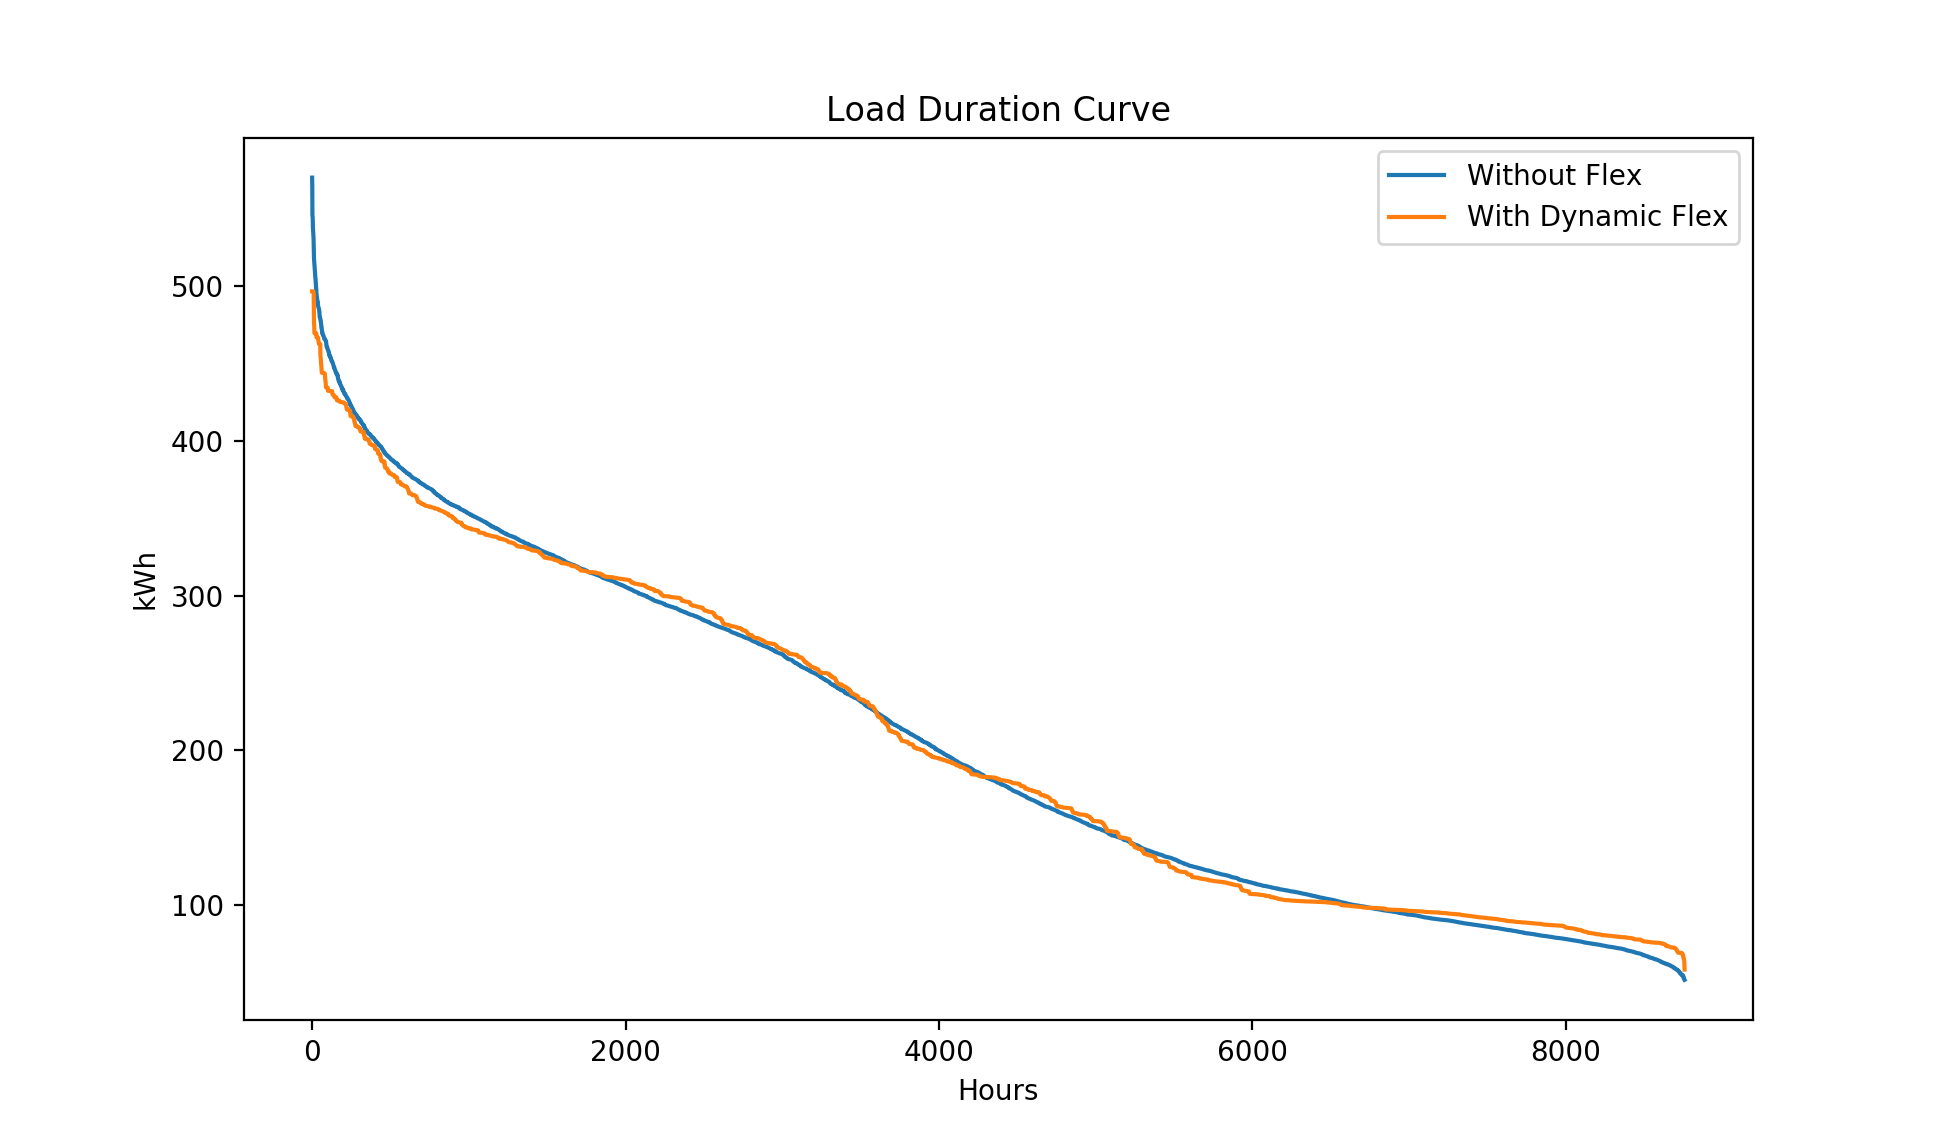

Sum before:  7632356.708500003
Sum after:  7632546.891727988


Peak before: 636.1940000000001
Peak after: 589.1310485190269


In [10]:
%matplotlib notebook
df = station.dataframe['2018']

plt.plot(df['AggregatedLoad'].sort_values(ascending=False).tolist()[:-1])
plt.plot(df['OptimalLoad'].sort_values(ascending=False).tolist()[:-1])
plt.legend(['Without Flex','With Dynamic Flex'])
plt.ylabel('kWh')
plt.xlabel('Hours')
plt.title('Load Duration Curve')
plt.show()

print('Sum before: ',sum(station.dataframe['AggregatedLoad']))
print('Sum after: ',sum(station.dataframe['OptimalLoad']))
print('\n')
print('Peak before:',station.dataframe['AggregatedLoad'].max())
print('Peak after:',station.dataframe['OptimalLoad'].max())

In [8]:
lst = df['OptimalLoad'].sort_values(ascending=False).tolist()
lst[-1]

-167.88527066481373

In [29]:
(9*50*30)/(8760*100)

0.015410958904109588

In [27]:
(666.2419999999998-632.489)/666.2419999999998

0.05066177154847611